# Informed MWTA

## Intro
* **Date**: 10/22/2022
* **What**: Yesterday's network didn't work.  And I kinda want to figure out why.  Basically, I think that I need to pay attention to distinguishing features between different digits  
* **Why**: Idk, I want to
* **Hopes**: Cool patterns
* **Limitations**: idk

## Code

In [2]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

m_len = 60_000
m_area = 28 * 28

(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

x_tr = x_tr / 255.0
x_te = x_te / 255.0

In [3]:
flat_tr = x_tr.reshape(-1, m_area)
flat_cr = np.zeros((m_len, 10))

for i in range(m_len):
    flat_cr[i, y_tr[i]] = 1

flat_te = x_te.reshape(-1, m_area)
flat_ce = np.zeros((len(x_te), 10))
for i in range(len(x_te)):
    flat_ce[i, y_te[i]] = 1

gp_ftr = cp.asarray(flat_tr)
gp_cr = cp.asarray(flat_cr)
gp_fte = cp.asarray(flat_te)
gp_ce = cp.asarray(flat_ce)

In [5]:
def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

<IPython.core.display.Javascript object>


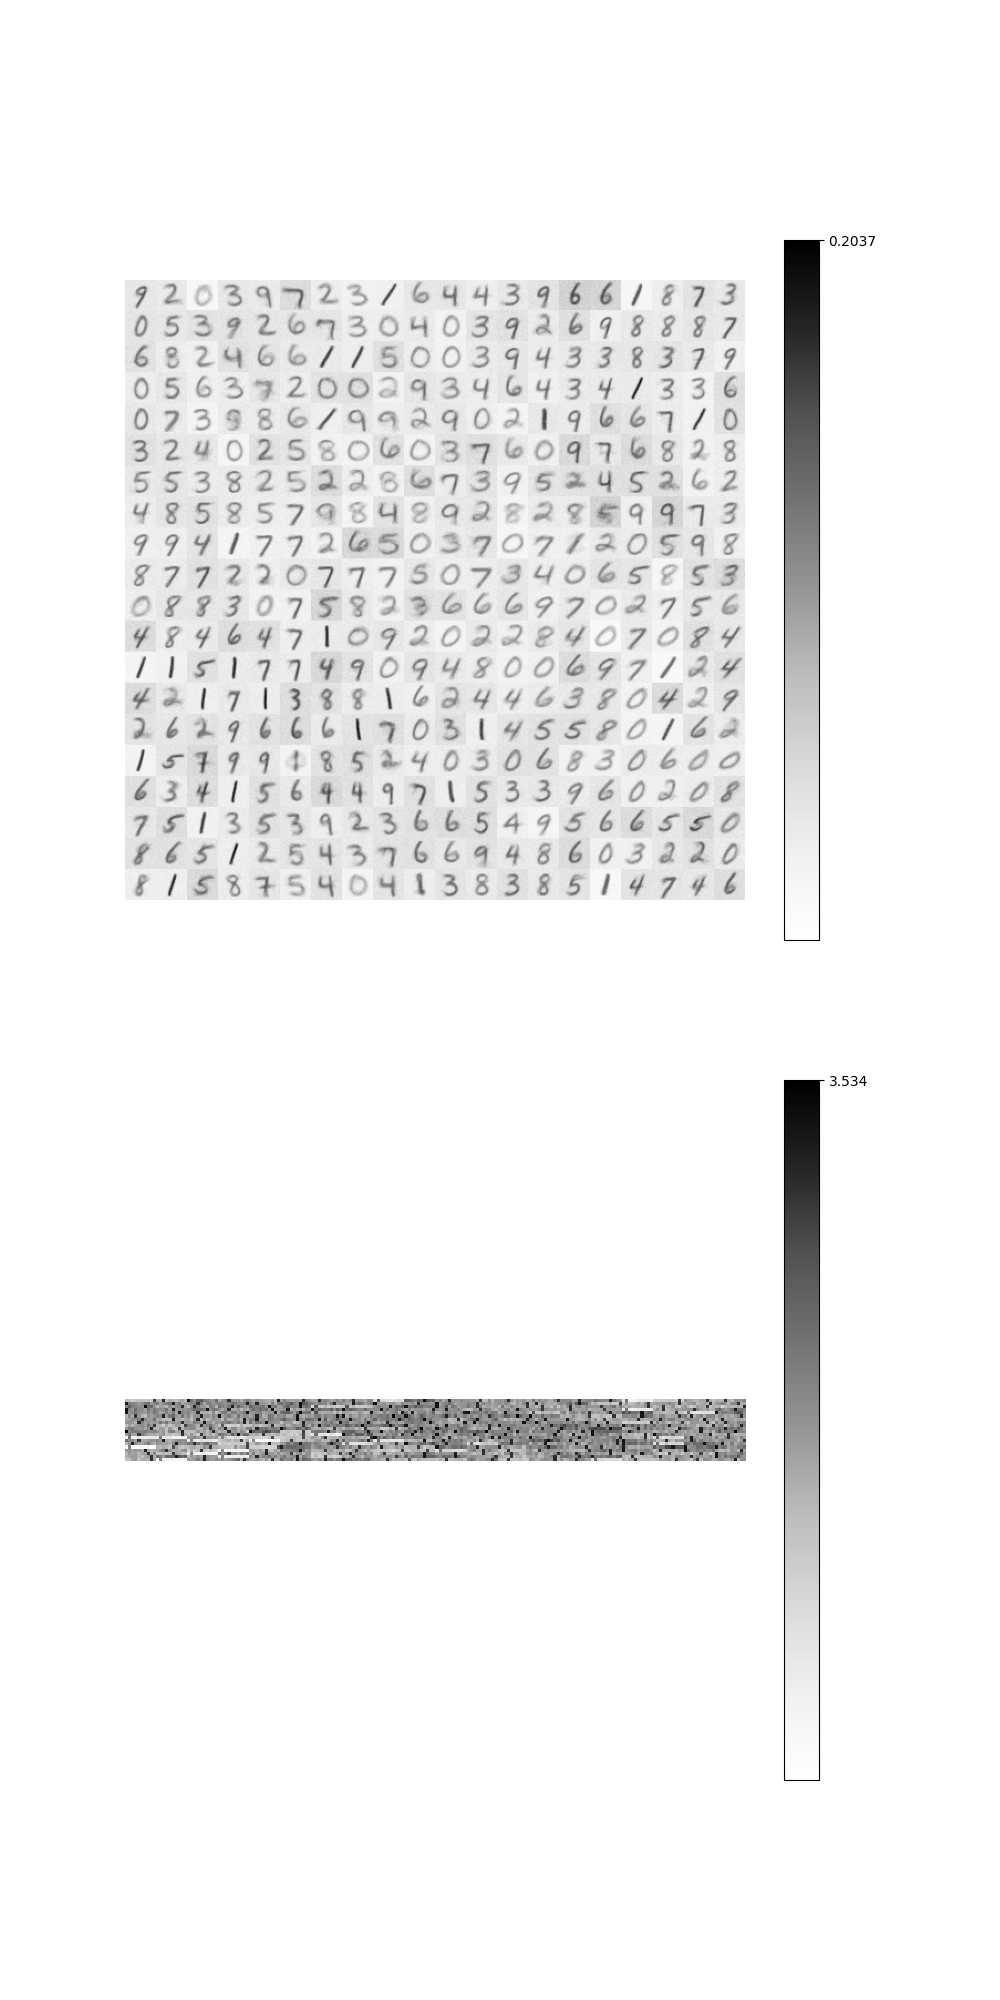

In [32]:
fig = plt.figure(figsize=(10, 20))

def draw_higher_order_weights(fig):
    fig.clf()
    def draw_iv(w, Kx, Ky, s_len_x, s_len_y, fig, i):
        tapestry = np.zeros((s_len_y * Ky, s_len_x * Kx))

        w_i = 0
        for y in range(Ky):
            for x in range(Kx):
                tapestry[y * s_len_y: (y + 1) * s_len_y, x * s_len_x: (x + 1) * s_len_x] = w[w_i].reshape(s_len_y, s_len_x)
                w_i += 1

        plt.subplot(2, 1, i)
    #     plt.clf()        
        max_val = np.max(tapestry)
        im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
        fig.colorbar(im, ticks=[0, max_val])
        plt.axis("off")
#         fig.canvas.draw()
    draw_iv(w1.get(), S1x, S1y, 28, 28, fig, 1)
#     draw_iv(w2.get(), S1x, S1y, Ivy, Ivx, fig, 2)
#     draw_iv(w3.get(), S2x, S2y, Ivy, Ivx, fig, 3)
    draw_iv(w2.get(), S1x, S1y, 10, 1, fig, 2)
    fig.canvas.draw()

draw_higher_order_weights(fig)

In [23]:
def gen_lat_ex(Kx, Ky, ex, coeff):

    lat_ex = []

    for y in range(Ky):
        for x in range(Kx):
            curr_ex = np.zeros((Ky, Kx))
            curr_ex[max(0, y - ex): min(Ky, y + ex + 1), max(0, x - ex): min(Kx, x + ex + 1)] = 1

            if y - ex < 0:
                curr_ex[y - ex:, max(0, x - ex): min(Kx, x + ex + 1)] = 1
            if y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, max(0, x - ex): min(Kx, x + ex + 1)] = 1

            if x - ex < 0:
                curr_ex[max(0, y - ex): min(Ky, y + ex + 1), x - ex:] = 1
            if x + ex + 1 > Kx:
                curr_ex[max(0, y - ex): min(Ky, y + ex + 1), :x + ex + 1 - Kx] = 1

            if y - ex < 0 and x - ex < 0:
                curr_ex[y - ex:, x - ex:] = 1

            if x + ex + 1 > Kx and y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, :x + ex + 1 - Kx] = 1

            if y - ex < 0 and x + ex + 1 > Kx:
                curr_ex[y - ex:, :x + ex + 1 - Kx] = 1


            if x - ex < 0 and y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, x - ex:] = 1

            lat_ex.append(curr_ex.reshape(-1))

    lat_ex = cp.array(lat_ex)
    np.fill_diagonal(lat_ex, 0)

    lat_ex = (lat_ex / cp.linalg.norm(lat_ex, axis=1).reshape(-1, 1)) * coeff
    np.fill_diagonal(lat_ex, 1)
    
    return lat_ex

<IPython.core.display.Javascript object>


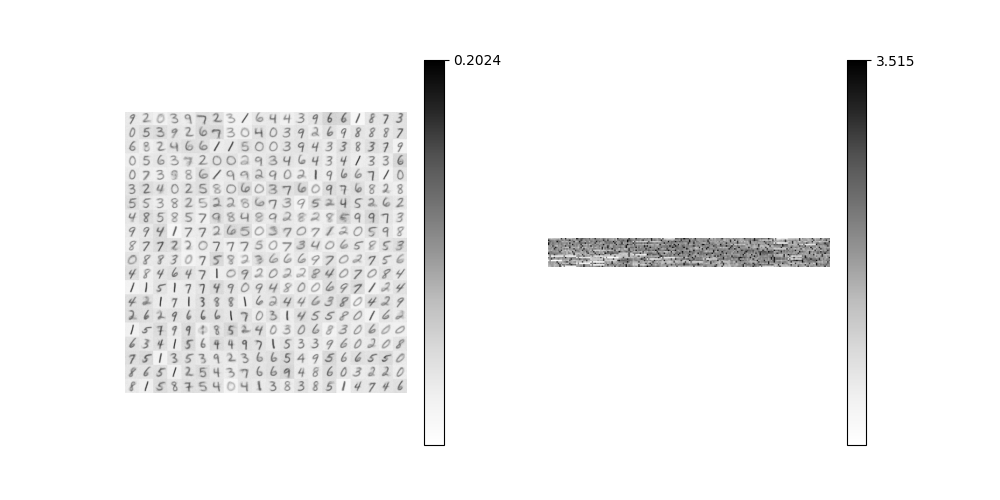

 18%|█▊        | 185/1000 [00:00<00:02, 276.53it/s]


KeyboardInterrupt: 

In [29]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 20
S1y = 20

NS1 = S1x * S1y

xi = 0.01

sex = 3
sex_coeff = 0.5

s_lat_ex = gen_lat_ex(S1x, S1y, sex, sex_coeff)


# In - Sparse 1
w1 = cp.random.uniform(0, 0.2, (NS1, m_len))
n_w1 = 1 #Number of winners

w2 = cp.random.uniform(0, 0.8, (NS1, 10))


Nep = 40
T_s = 1000
hw1 = .5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
#         iv_bottom = cp.zeros((NIv, 1))
#         iv_top = cp.zeros((NIv, 1))
        
#         s2_bottom = cp.zeros((NS2, 1))
#         s2_top = cp.zeros((NS2, 1))
        
        
            
        s1_bottom = w1 @ v
        bottom_comp = s_lat_ex @ s1_bottom # Lat ex

        s1_top = w2 @ cl

        s1_comp = (hw1 * bottom_comp / cp.max(bottom_comp)) + ((1 - hw1) * s1_top / cp.max(s1_top))
        s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
        s1_top = cp.zeros((NS1, 1))
        s1_top[s1_winners] = 1
        s1_bottom *= s1_top
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        w1 += cc1        
            
        r4 = w2.T @ s1_top
        mod_r4 = cp.maximum(r4, prec)
        e4 = cl - r4
        
        w2 += w2 * s1_top * (e4 / mod_r4).T * xi
        
        if i % 50 == 0:
            w1 += cp.random.uniform(0, 0.002, (NS1, m_len))
            w2 += cp.random.uniform(0, 0.01, (NS1, 10))
#             w3 += cp.random.uniform(0, 0.05, (NS2, NIv))
#             w4 += cp.random.uniform(0, 0.05, (NS2, 10))
        
    draw_higher_order_weights(fig)

Ok, interesting.  Let's start looking at what happens when we start breaking up shit...


<IPython.core.display.Javascript object>


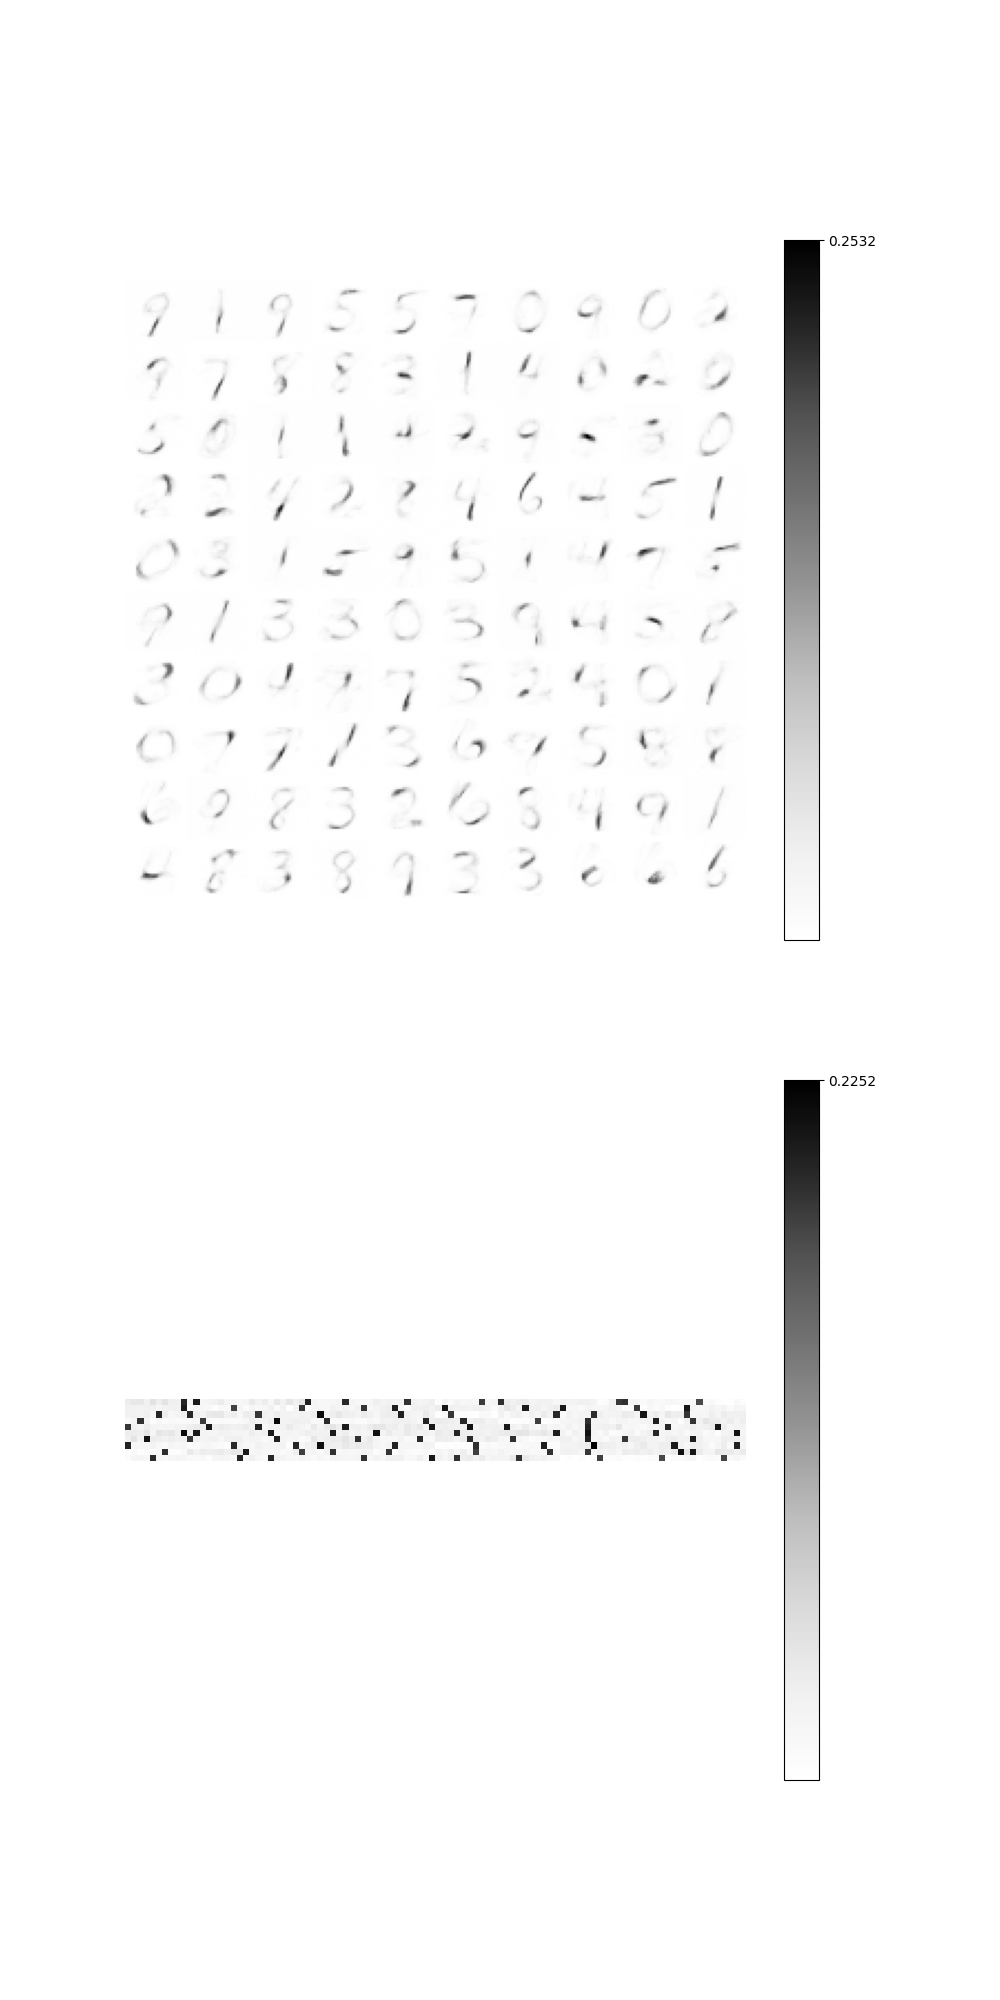

 20%|██        | 1214/6000 [00:02<00:10, 458.11it/s]


KeyboardInterrupt: 

In [43]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 20))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 10
S1y = 10

NS1 = S1x * S1y

xi = 0.05

sex = 3
sex_coeff = 0.5

s_lat_ex = gen_lat_ex(S1x, S1y, sex, sex_coeff)


# In - Sparse 1
w1 = cp.random.uniform(0, 0.2, (NS1, m_len))
n_w1 = 6 #Number of winners

w2 = cp.random.uniform(0, 0.8, (NS1, 10))


Nep = 40
T_s = 6000
hw1 = 0.5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
#         iv_bottom = cp.zeros((NIv, 1))
#         iv_top = cp.zeros((NIv, 1))
        
#         s2_bottom = cp.zeros((NS2, 1))
#         s2_top = cp.zeros((NS2, 1))
        
        
            
        s1_bottom = w1 @ v
#         bottom_comp = s1_bottom
        bottom_comp = s_lat_ex @ s1_bottom # Lat ex

        s1_top = w2 @ cl

        s1_comp = (hw1 * bottom_comp / cp.max(bottom_comp)) + ((1 - hw1) * s1_top / cp.max(s1_top))
        s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
        s1_top = cp.zeros((NS1, 1))
        s1_top[s1_winners] = 1
        s1_bottom *= s1_top
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        w1 += cc1        
            
        r4 = w2.T @ s1_top
        mod_r4 = cp.maximum(r4, prec)
        e4 = cl - r4
        
        w2 += w2 * s1_top * (e4 / mod_r4).T * xi
        
        if i % 50 == 0:
            w1 += cp.random.uniform(0, 0.001, (NS1, m_len))
            w2 += cp.random.uniform(0, 0.01, (NS1, 10))
#             w3 += cp.random.uniform(0, 0.05, (NS2, NIv))
#             w4 += cp.random.uniform(0, 0.05, (NS2, 10))
        
    draw_higher_order_weights(fig)

<IPython.core.display.Javascript object>


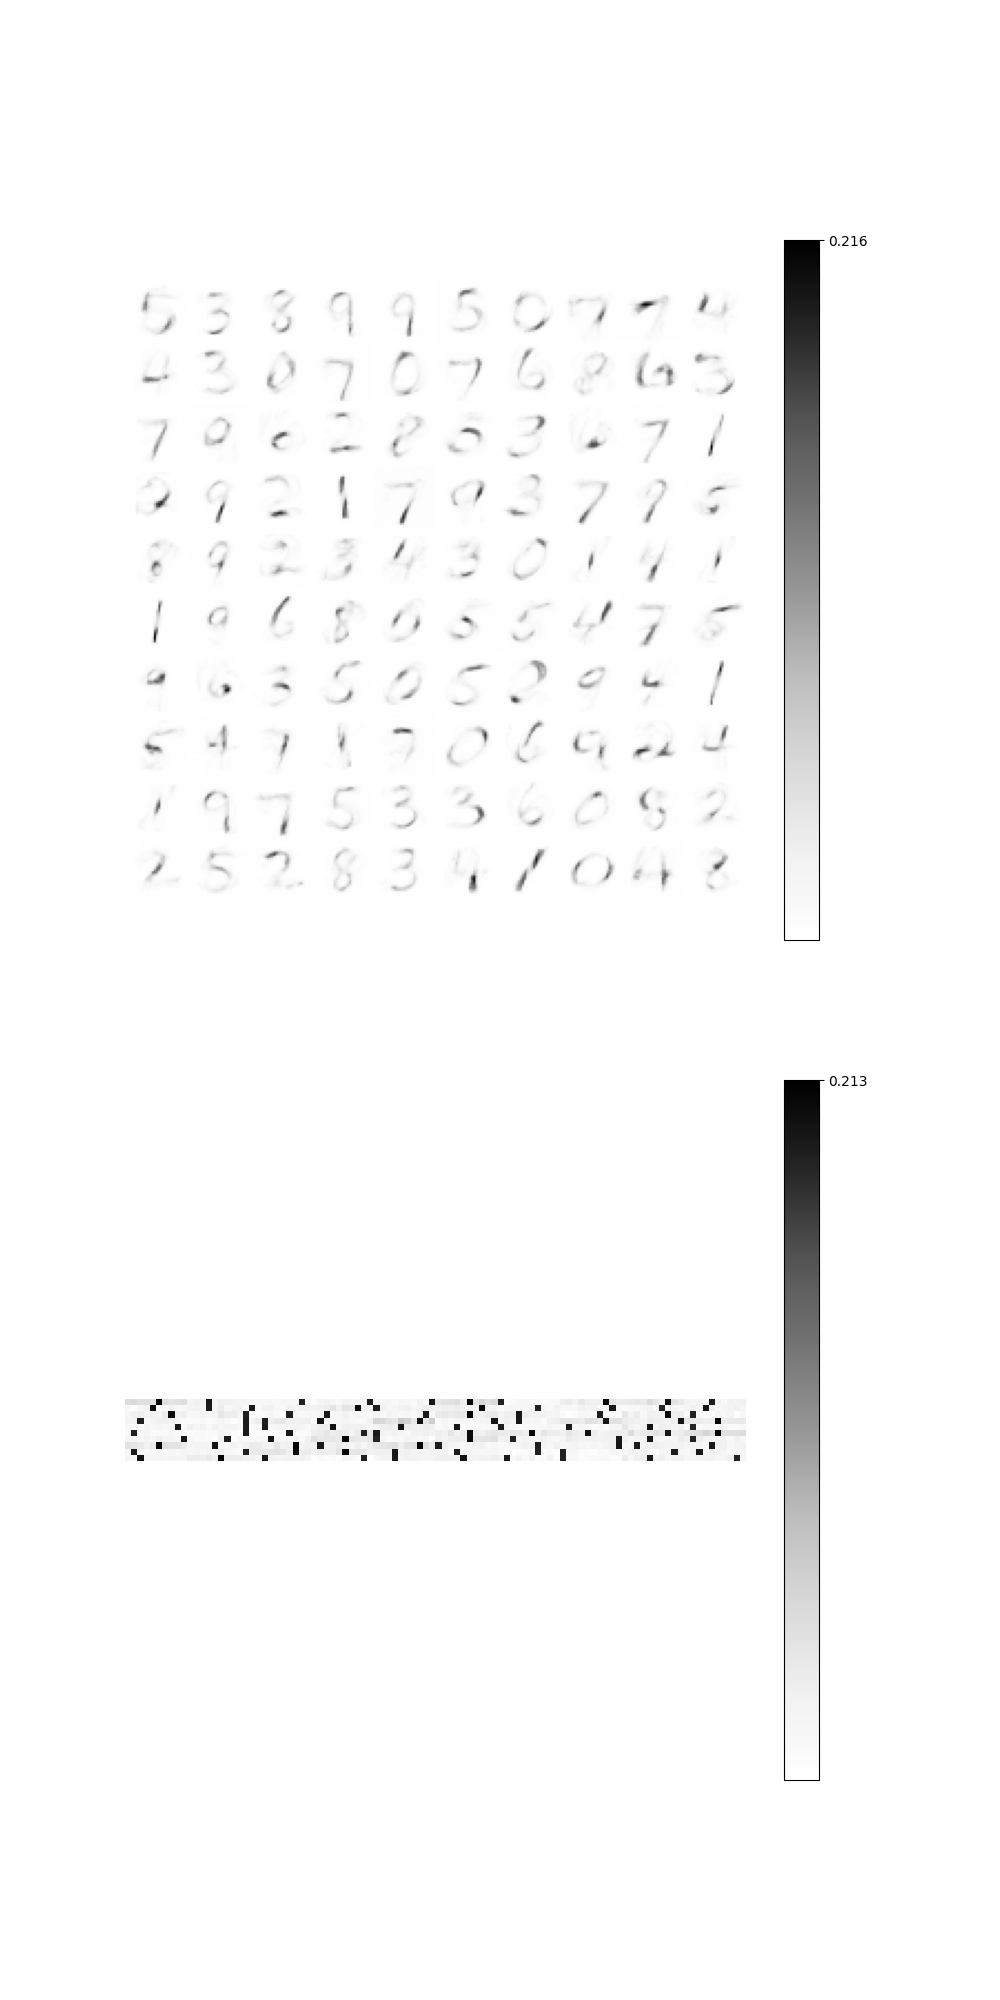

 65%|██████▍   | 3896/6000 [00:08<00:03, 584.47it/s]

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 20))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 10
S1y = 10

NS1 = S1x * S1y

xi = 0.05

sex = 3
sex_coeff = 0.5

s_lat_ex = gen_lat_ex(S1x, S1y, sex, sex_coeff)


# In - Sparse 1
w1 = cp.random.uniform(0, 0.2, (NS1, m_len))
n_w1 = 6 #Number of winners

w2 = cp.random.uniform(0, 0.8, (NS1, 10))


Nep = 40
T_s = 6000
hw1 = 0.2 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
#         iv_bottom = cp.zeros((NIv, 1))
#         iv_top = cp.zeros((NIv, 1))
        
#         s2_bottom = cp.zeros((NS2, 1))
#         s2_top = cp.zeros((NS2, 1))
        
        
            
        s1_bottom = w1 @ v
#         bottom_comp = s1_bottom
        bottom_comp = s_lat_ex @ s1_bottom # Lat ex

        s1_top = w2 @ cl

        s1_comp = (hw1 * bottom_comp / cp.max(bottom_comp)) + ((1 - hw1) * s1_top / cp.max(s1_top))
        s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
        s1_top = cp.zeros((NS1, 1))
        s1_top[s1_winners] = 1
        s1_bottom *= s1_top
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        w1 += cc1        
            
        r4 = w2.T @ s1_top
        mod_r4 = cp.maximum(r4, prec)
        e4 = cl - r4
        
        w2 += w2 * s1_top * (e4 / mod_r4).T * xi
        
        if i % 50 == 0:
            w1 += cp.random.uniform(0, 0.001, (NS1, m_len))
            w2 += cp.random.uniform(0, 0.01, (NS1, 10))
#             w3 += cp.random.uniform(0, 0.05, (NS2, NIv))
#             w4 += cp.random.uniform(0, 0.05, (NS2, 10))
        
    draw_higher_order_weights(fig)